In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays 
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"] # number of products
N_x = Params["N_x"] # dimension of product features
c_l = Params["c_l"] 
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"] # dimension of customer features
S_train = Params["S_train"] # training data size
S_test = Params["S_test"] # test data size
N_Max = Params["N_Max"] # maximum assortment size
N_nonzero = Params["N_nonzero"] # number of nonzero entries in A
Time_Limit = Params["Time_Limit"] # time limit for optimization
dual_norm = Params["dual_norm"] # dual norm for robust optimization
gamma_list = Params["gamma_list"] # list of gamma values for robust optimization
psi_lb = Params["psi_lb"] # lower bound for psi
psi_ub = Params["psi_ub"] # upper bound for psi
phi_lb = Params["phi_lb"]   # lower bound for phi
phi_ub = Params["phi_ub"]  # upper bound for phi
num_c = Params["num_c"] # number of customer segments
instances = Params["instances"] # number of instances
seed = Params["seed"] # random seed
coef_this = Params["coef_this"] # coefficient for data generation
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"] # coefficient for Wang, Qi, Shen data generation

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = false;
is_same_util_para = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    coef_para_Input = coef_this;
    project_dir = "Test_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_para_Input);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/")

data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/Codes/Data/Product_Line_Design/Test_N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=1_Same_Util_Para/


In [4]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

### Lambda = 0.0

In [5]:
is_ridge = true
lambda_all = [0.01]
S_train_list = [50]
gamma_list = Params["gamma_list_Wang_Qi_Max"]
psi_lb = -5 * ones(Params["N"])
psi_ub = 0 * ones(Params["N"])
phi_lb = -5 * ones(Params["N"])
phi_ub = 0 * ones(Params["N"])
norm_bounds = 20
Time_Limit = 360
instances = 100

100

In [6]:
d_r = ones(Params["N"]) * 4
gamma_list = [0.0,0.05,0.1,0.15,0.2,0.25]

6-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25

In [7]:
for lambda in lambda_all
    for S_train in S_train_list
        println("********** S_train = ",S_train," **********")

        Input_Data = Dict()
        RST_True_All = Dict()
        RST_ETO_All = Dict()
        RST_RO_All = Dict()
        ins = 1
        while ins <= instances
            # ******** Data generation *************
            if is_same_util_para
                Input_Data_this = Generate_Data_this_Same_Para(N_Max,N_x,N_u,S_train,S_test,theta_true_Fixed, r_params_Fixed);
            else
                Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
            end
            theta_true,r_params,X_train,Y_train,Z_train,Asorrtment_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this);
            nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
            nu_all_true = [nu0_true;nu_true]

            # ******** Estimation *************
            theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, Asorrtment_train,is_ridge, lambda)
            nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
            nu_all_hat = [nu0_hat;nu_hat]
            if any(isnan, nu_all_hat)
                println("Estimate contains NaN values.")
                continue
            end
            if norm(vec(nu_all_true .- nu_all_hat),2) >= norm_bounds
                println("Estimate is too far from true parameters.")
                continue
            end
            Input_Data_this["theta_hat"] = theta_hat
            Input_Data_this["nu_true"] = nu_all_true
            Input_Data_this["nu_hat"] = nu_all_hat
            Input_Data["ins=$(ins)"] = Input_Data_this

            # ******** True Model *************
            theta_Input = theta_true
            RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
            # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
            if status_True != "OPTIMAL"
                println("Warning: The true model did not reach optimality")
                continue
            end
            RST_True_All["ins=$(ins)"] = RST_True

            # ******** ETO Model *************
            RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
            # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
            if status_ETO != "OPTIMAL"
                println("Warning: The ETO model did not reach optimality")
                continue
            end
            RST_ETO_All["ins=$(ins)"] = RST_ETO
            
            # ******** RO Model *************
            RST_RO_this = Dict()
            gamma = gamma_list[1]
            RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
            # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
            if status_RO != "OPTIMAL"
                println("Warning: The RO model did not reach optimality")
                continue
            end
            ratio = abs(RST_RO["obj"][1] - RST_ETO["obj"][1])/abs(RST_ETO["obj"][1])
            # ratio = abs(RST_RO["profit"][1] - RST_ETO["profit"][1])/abs(RST_ETO["profit"][1])
            if ratio > 1e-3
                println("Warning: The RO obj is not equivalent to ETO obj: ETO_Obj=",RST_ETO["obj"][1],",RO_Obj=",RST_RO["obj"][1])
                continue
            end
            RST_RO_this[string("gamma=",gamma)] = RST_RO

            for g_index in 2:length(gamma_list)
                gamma = gamma_list[g_index]
                RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
                # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
                RST_RO_this[string("gamma=",gamma)] = RST_RO
            end
            RST_RO_All["ins=$(ins)"] = RST_RO_this
            println("******* ins = ",ins,"*********")
            ins = ins + 1
        end
        save(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"), Input_Data);
        save(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"), RST_True_All);
        save(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"), RST_ETO_All);
        save(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"), RST_RO_All);
    end
end

********** S_train = 50 **********
******* ins = 1*********
******* ins = 2*********
******* ins = 3*********
******* ins = 4*********
******* ins = 5*********
******* ins = 6*********
******* ins = 7*********
******* ins = 8*********
******* ins = 9*********
******* ins = 10*********
******* ins = 11*********
******* ins = 12*********
******* ins = 13*********
******* ins = 14*********
******* ins = 15*********
******* ins = 16*********
******* ins = 17*********
******* ins = 18*********
******* ins = 19*********
******* ins = 20*********
******* ins = 21*********
******* ins = 22*********
******* ins = 23*********
******* ins = 24*********
******* ins = 25*********
******* ins = 26*********
******* ins = 27*********
******* ins = 28*********
******* ins = 29*********
******* ins = 30*********
******* ins = 31*********
******* ins = 32*********
******* ins = 33*********
******* ins = 34*********
******* ins = 35*********
******* ins = 36*********
******* ins = 37*********
******* ins 

## S = 50

In [8]:
function output_results(S_train,lambda,data_dir,instances,fig_display)
    Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
    RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

    gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
    gamma_list = gamma_list
    # println("Gamma list: ", gamma_list)

    obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),obj True:",round.(mean(obj_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj ETO:",round.(mean(obj_ETO),digits=4))
    println("S=$(S_train),lambda=$(lambda),obj RO:",round.(mean(obj_RO,dims=1),digits=4))
    println()
    profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
    println("S=$(S_train),lambda=$(lambda),profit True:",round.(mean(profit_True),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit ETO:",round.(mean(profit_ETO),digits=4))
    println("S=$(S_train),lambda=$(lambda),profit RO:",round.(mean(profit_RO,dims=1),digits=4))

    fig_name = string(data_dir, "RPLD_vs_ETOPLD_S=$(S_train)_lambda=$lambda.pdf")
    include_std = false
    line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name,fig_display)
end

output_results (generic function with 1 method)

S=50,lambda=0.01,obj True:0.9215
S=50,lambda=0.01,obj ETO:0.9276
S=50,lambda=0.01,obj RO:[0.9276 0.9088 0.8898 0.8707 0.8522 0.8337]

S=50,lambda=0.01,profit True:0.9215
S=50,lambda=0.01,profit ETO:0.8687
S=50,lambda=0.01,profit RO:[0.8687 0.8747 0.8802 0.8844 0.887 0.8841]


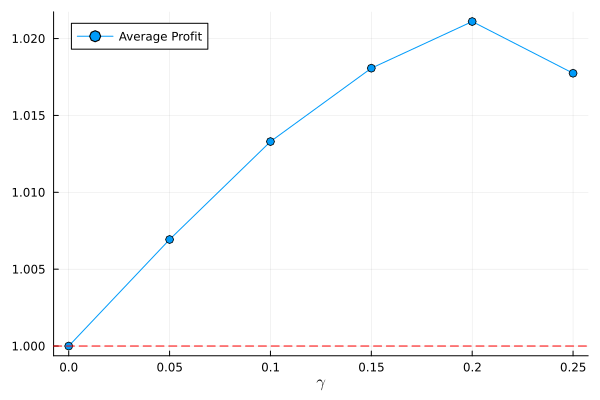

"/Users/zhangxun/Codes/Data/Product_Line_Design/Test_N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=1_Same_Util_Para/RPLD_vs_ETOPLD_S=50_lambda=0.01.pdf"

In [9]:
lambda = lambda_all[1]
S_train = S_train_list[1]
output_results(S_train,lambda,data_dir,instances,true)

### Check Results

In [10]:
# lambda = lambda_all[1]
# S_train = 50

# Input_Data = load(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
# RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

# gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
# gamma_list = gamma_list
# # println("Gamma list: ", gamma_list)

# obj_True, obj_ETO, obj_RO = obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("S=$(S_train),lambda=$(lambda),obj True:",round.(mean(obj_True),digits=4))
# println("S=$(S_train),lambda=$(lambda),obj ETO:",round.(mean(obj_ETO),digits=4))
# println("S=$(S_train),lambda=$(lambda),obj RO:",round.(mean(obj_RO,dims=1),digits=4))
# println()
# profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
# println("S=$(S_train),lambda=$(lambda),profit True:",round.(mean(profit_True),digits=4))
# println("S=$(S_train),lambda=$(lambda),profit ETO:",round.(mean(profit_ETO),digits=4))
# println("S=$(S_train),lambda=$(lambda),profit RO:",round.(mean(profit_RO,dims=1),digits=4))


In [11]:
# ins = 2
# nu_true = Input_Data["ins=$ins"]["nu_true"];
# nu_hat = Input_Data["ins=$ins"]["nu_hat"];
# r_params = Input_Data["ins=$ins"]["r_params"];

In [12]:
# function obtain_probs(Design, nu_true)
#     utilties = Design * nu_true[2:end] .+ nu_true[1]
#     exp_utilities = exp.(utilties)
#     prob = exp_utilities ./ (sum(exp_utilities)+1)
#     return utilties,exp_utilities,prob
# end

In [13]:
# price_coefs = round.(r_params.r,digits=4)
# println("price coef:",price_coefs)

- True Results

In [14]:
# Design_True = RST_True_All["ins=$ins"]["X"][1,:,:];

In [15]:
# price_True = Design_True * price_coefs;
# println("price True = ", round.(price_True,digits=4))

In [16]:
# utilties_True,exp_utilities_True,prob_True = obtain_probs(Design_True, nu_true);
# println("probs True = ",round.(prob_True,digits=4))
# println("Rev True = ",round.(price_True' * prob_True,digits=4))

- ETO Results

In [17]:
# Design_ETO = RST_ETO_All["ins=$ins"]["X"][1,:,:];

In [18]:
# price_ETO = Design_ETO * price_coefs;
# println("price ETO = ", round.(price_ETO,digits=4))

In [19]:
# utilties_ETO,exp_utilities_ETO,prob_ETO = obtain_probs(Design_ETO, nu_true);
# println("probs ETO = ",round.(prob_ETO,digits=4))
# println("Rev ETO = ",price_ETO' * prob_ETO)